In [ ]:
# importacion de librerias
from scipy import stats
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from sklearn.metrics import recall_score

In [ ]:
tick = "ETH-USD"

In [ ]:
fecha_hoy = pd.Timestamp.today().strftime('%Y-%m-%d') #obtencion de la fecha de hoy
fecha_hoy

'2023-07-26'

In [ ]:
df = yf.download(tick, start="2015-01-01", end=fecha_hoy ) #tick = BTC = bitcoin; descargo de yahoofinance el historial de bitcoin desde fecha start hasta fecha_hoy

[*********************100%***********************]  1 of 1 completed


In [ ]:

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-07-20,1889.073730,1919.264404,1879.734375,1890.969116,1890.969116,7366830684
2023-07-21,1891.581299,1905.386230,1885.296265,1892.080078,1892.080078,4668158260
2023-07-22,1891.955078,1897.088013,1855.092773,1864.912354,1864.912354,4101305643


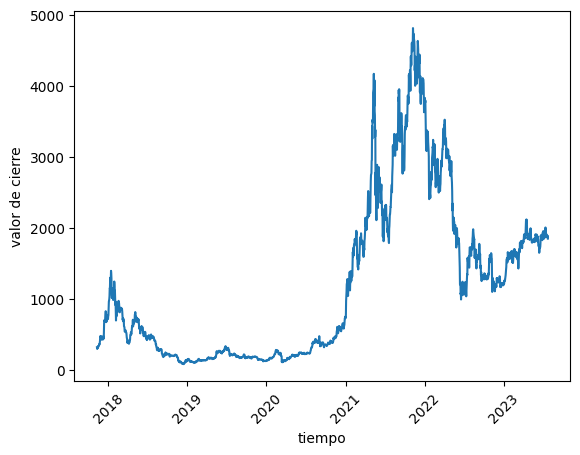

In [ ]:
#grafica de como el valor de close va subiendo o bajando, basicamente el valor de la accion
plt.xlabel("tiempo")
plt.ylabel("valor de cierre")
plt.plot(df['Close'])
plt.xticks(rotation = 45)
plt.show()

In [ ]:
#obtengo la diferencia de open y close
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low # tambien la de high y low que es mayor y menor precio de la accion en ese dia

X = df[['Open-Close','High-Low']] #de lo anterior obtengo mis datos de input
X.head()

,Open-Close,High-Low
Date,,
2017-11-09,-12.239014,22.395996
2017-11-10,21.417999,30.175995
2017-11-11,-16.095001,21.261017
2017-11-12,6.782013,20.640015
2017-11-13,-9.691010,21.390015


In [ ]:
type(X)

pandas.core.frame.DataFrame

In [ ]:
#para los datos objetivo esta funcion que sirve para comparar si el valor de la accion es mayor o menor que el dia anterior
y = np.where(df['Close'].shift(-1) > df['Close'],1,0)
type(y)

numpy.ndarray

In [ ]:
len(y)

2084

In [ ]:
#divido los datos X y "y" en entrenamiento y test
split_percentage = 0.8
split = int(split_percentage * len(df))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [ ]:
print(len(X_train),len(y_train))

1664 1664


In [ ]:
X_train.shape

(1664, 2)

In [ ]:
y_train.shape

(1664,)

In [ ]:
#modelo RNA red neuronal artificial clasico
model = tf.keras.Sequential([
    tf.keras.layers.Input((None,2,)), #None,2(datos de input tiene dos dimensiones) luego ",)" los datos y cualquier dimension
    tf.keras.layers.Dense(64,activation='relu'), #1era capa 64 neuronas, activacion relu(todas se conectan con todas)
    tf.keras.layers.Dropout(0,2), #capa dropout para descartar unas cuantas neuronas 0,2 = 20%
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid') #sigmoid para que la salida sea una probabilidad entre si es 1 o 0 osea me dara por ejemplo un dato (0.41234) osea aprox 40% de que sea 1
])

In [ ]:
#optimizador adam para clasificacion binaria
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.binary_crossentropy,
             metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=1000, verbose = False) #entrenar el modelo, 1000 epcoh = 1000 vueltas que hara para aprender

In [ ]:
predicciones = model.predict(X_test) #predigo con los datos X_test

14/14 [==============================] - 0s 1ms/step


In [ ]:
out = predicciones.round().astype(int) #aca es importante, con esta funcion convierto la probabilidad a valores 0 o 1 depende si es mas de 0.5

In [ ]:
# Calcular el recall en el conjunto de datos de prueba, si resulta 1 quiere decir que predice todo bien
recall = recall_score(y_test, out)
print(f"Recall en datos de prueba: {recall}")

Recall en datos de prueba: 0.7614213197969543


In [ ]:
# 0.34328358208955223, 0.31343283582089554


In [1]:
# Calculate daily returns
df['Return'] = df.Close.pct_change() #funcion para sacar el porcentaje de aumento o disminucion
df['Return']

NameError: ignored

In [2]:
df['Predicted_Signal'] = model.predict(X).round().astype(int) #predigo los datos del dataframe X que antes dividi en entrenamiento y test
df['Predicted_Signal']

NameError: ignored

In [ ]:
# Calculate strategy returns
df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)
df['Strategy_Return']

Date
2017-11-09         NaN
2017-11-10   -0.000000
2017-11-11    0.051555
2017-11-12   -0.000000
2017-11-13    0.028606
                ...   
2023-07-17   -0.006257
2023-07-18   -0.007348
2023-07-19   -0.004527
2023-07-20    0.001038
2023-07-21    0.000588
Name: Strategy_Return, Length: 2081, dtype: float64

In [3]:
# Calculate Cumulutive returns
df['Cum_Ret'] = df['Return'].cumsum()

# Plot Strategy Cumulative returns
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()


NameError: ignored

(array([17167., 17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

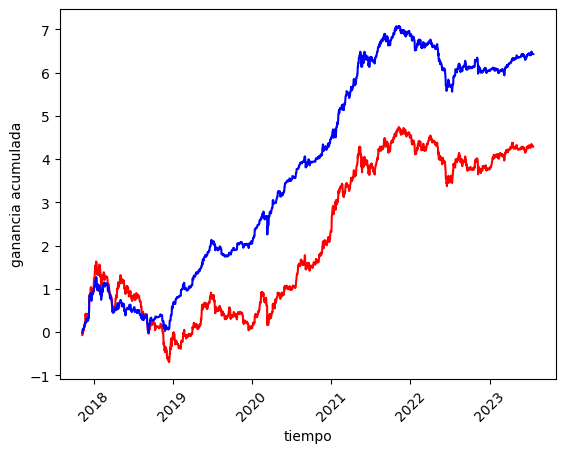

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("tiempo")
plt.ylabel("ganancia acumulada")

plt.plot(df['Cum_Ret'],color='red')
plt.plot(df['Cum_Strategy'],color='blue')
plt.xticks(rotation = 45)